# Debugging and sanity checks of f4 ration Nea. estimates

In [1]:
suppressMessages({

library(tidyverse)
library(admixr)

source("../R/utils.R")

})

In [2]:
library(devtools)
reload(inst("admixr"))

Reloading installed admixr


In [3]:
samples <- load_samples()

Warning message:
“Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]”

In [4]:
load("../RData/admixtools_debugging.RData")

# Tests on Qiaomei's data

In [4]:
EIGENSTRAT_DIR <- "../raw_data/eigenstrat_all//"

EIGENSTRAT <- paste0(EIGENSTRAT_DIR, "UPA_merged_all")

SNP_FILE <- paste0(EIGENSTRAT_DIR, "UPA_merged_all.snp")
GENO_FILE <- paste0(EIGENSTRAT_DIR, "UPA_merged_all.geno")
IND_FILE <- paste0(EIGENSTRAT_DIR, "UPA_merged_all.ind")

BADSNP_FILE <- paste0(EIGENSTRAT_DIR, "UPA_merged_all.transitions.snp")

Create a `badsnp` file containing transition SNPs:

In [5]:
read_snp(SNP_FILE) %>% 
    keep_transitions %>%
    filter(chrom %in% 1:22) %>%
    write_tsv(BADSNP_FILE, col_names=FALSE)

Parsed with column specification:
cols(
  id = col_character(),
  chrom = col_integer(),
  gen = col_double(),
  pos = col_integer(),
  alt = col_character(),
  ref = col_character()
)


## Old vs new processing of Altai

In [6]:
old_vs_new <- inner_join(
    by="X",
    qpF4ratio(X=samples$name, A="Altai", B="new_Vindija", C="Mbuti", O="Chimp", prefix=EIGENSTRAT) %>% rename(old_altai=alpha),
    qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp", prefix=EIGENSTRAT) %>% rename(new_altai=alpha),
) %>%
    rename(name=X) %>% 
    inner_join(samples) %>%
    select(name, old_altai, new_altai, pop)

Joining, by = "name"


Warning message:
“Removed 5 rows containing missing values (geom_point).”

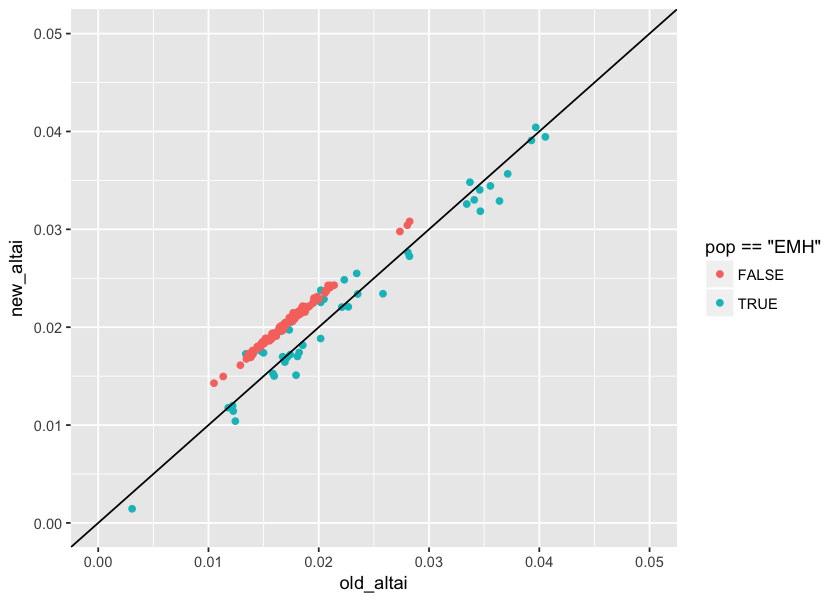

In [5]:
options(repr.plot.width=7, repr.plot.height=5)

ggplot(old_vs_new, aes(old_altai, new_altai, color=pop == "EMH")) +
    geom_point() +
    geom_abline(slope=1) +
    ylim(0, 0.05) + xlim(0, 0.05)

**TODO** Partition the EMH samples based on their library prep method.

## Old vs new processing of Altai - transversions only

In [8]:
tv_old_vs_new <- inner_join(
    by="X",
    qpF4ratio(X=samples$name, A="Altai", B="new_Vindija", C="Mbuti", O="Chimp", prefix=EIGENSTRAT, badsnp=BADSNP_FILE) %>% rename(old_tv_only=alpha),
    qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp", prefix=EIGENSTRAT, badsnp=BADSNP_FILE) %>% rename(new_tv_only=alpha),
) %>%
    rename(name=X) %>% 
    inner_join(samples) %>%
    select(name, old_tv_only, new_tv_only, pop)

Joining, by = "name"


Warning message:
“Removed 13 rows containing missing values (geom_point).”

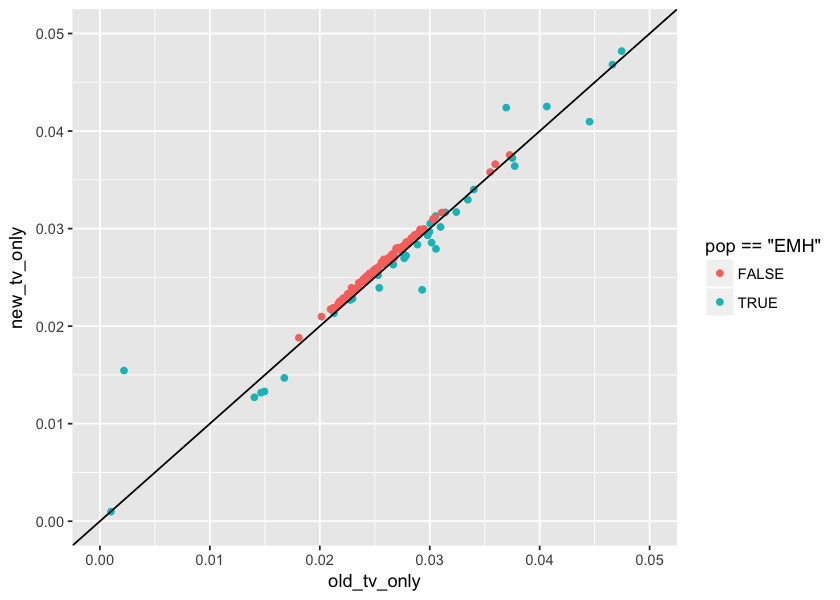

In [6]:
options(repr.plot.width=7, repr.plot.height=5)

ggplot(tv_old_vs_new, aes(old_tv_only, new_tv_only, color=pop == "EMH")) +
    geom_point() +
    geom_abline(slope=1) +
    ylim(0, 0.05) + xlim(0, 0.05)

The processing of Altai does not matter as long as we restrict to transversions only. Compare this to the previous plot, where there was a big difference in old vs new Altai processing.

This indicates that it really is a different way of calling genotypes in Altai vs Vindija that messes up things in the f4 ratio calculation.

## new Altai - Transversions-only vs all SNPs

In [10]:
tv_vs_all <- inner_join(
    by="X",
    qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp", prefix=EIGENSTRAT) %>% rename(all_snps=alpha),
    qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp", prefix=EIGENSTRAT, badsnp=BADSNP_FILE) %>% rename(tv_only=alpha),
) %>%
    rename(name=X) %>% 
    inner_join(samples) %>%
    select(name, all_snps, tv_only, pop)

Joining, by = "name"


Warning message:
“Removed 15 rows containing missing values (geom_point).”

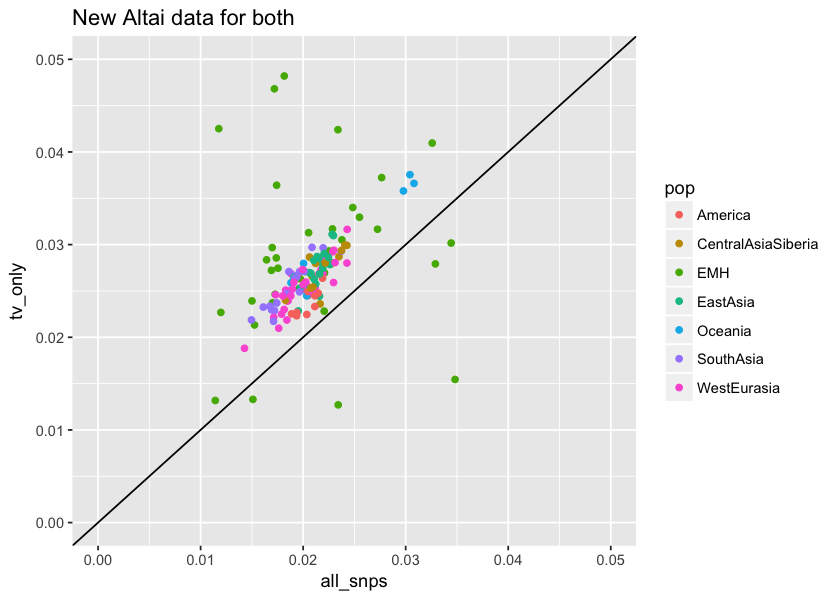

In [7]:
options(repr.plot.width=7, repr.plot.height=5)

ggplot(tv_vs_all, aes(all_snps, tv_only, color=pop)) +
    geom_point() +
    geom_abline(slope=1) +
    ylim(0, 0.05) + xlim(0, 0.05) + 
    ggtitle("New Altai data for both")

## Transversions-only vs all SNPs

In [12]:
old_tv_vs_all <- inner_join(
    by="X",
    qpF4ratio(X=samples$name, A="Altai", B="new_Vindija", C="Mbuti", O="Chimp", prefix=EIGENSTRAT) %>% rename(all_snps=alpha),
    qpF4ratio(X=samples$name, A="Altai", B="new_Vindija", C="Mbuti", O="Chimp", prefix=EIGENSTRAT, badsnp=BADSNP_FILE) %>% rename(tv_only=alpha),
) %>%
    rename(name=X) %>% 
    inner_join(samples) %>%
    select(name, all_snps, tv_only, pop)

Joining, by = "name"


Warning message:
“Removed 14 rows containing missing values (geom_point).”

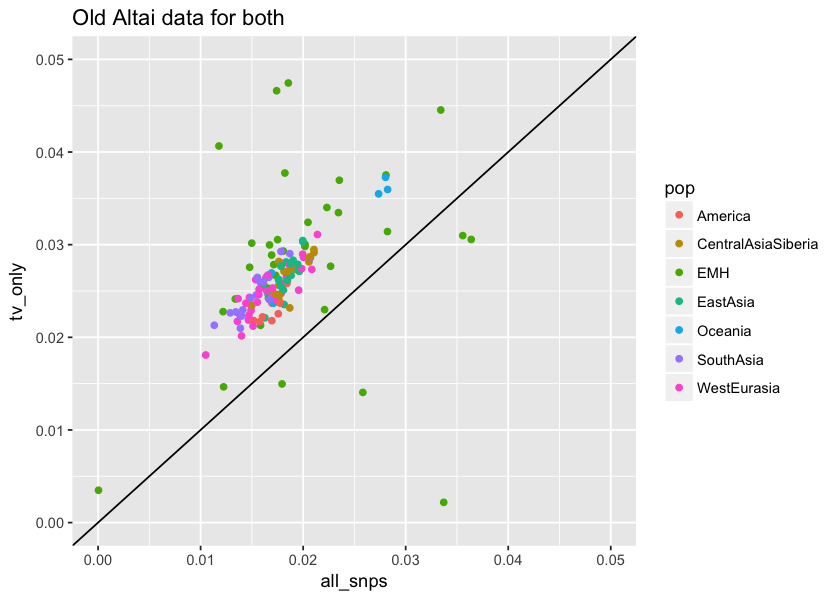

In [8]:
options(repr.plot.width=7, repr.plot.height=5)

ggplot(old_tv_vs_all, aes(all_snps, tv_only, color=pop)) +
    geom_point() +
    geom_abline(slope=1) +
    ylim(0, 0.05) + xlim(0, 0.05) + 
    ggtitle("Old Altai data for both")

Obviously, since TV-only results are perfectly correlated between old and new processing, this result looks the same as the one directly above.

## Does "manual" f4 calculation result in the same thing as `qpF4ratio` estimate?

#### Use two individual f4 statistics to calculate the f4 ratio of Nea. ancestry

In [34]:
num <- qpDstat(W=filter(samples, pop == "WestEurasia")$name, X="Mbuti", Y="new_Altai", Z="Chimp",
               prefix=EIGENSTRAT, f4mode=TRUE)

In [35]:
den <- qpDstat(W="new_Vindija", X="Mbuti", Y="new_Altai", Z="Chimp",
               prefix=EIGENSTRAT, f4mode=TRUE)

In [36]:
two_f4 <- mutate(num, alpha=Dstat/den$Dstat) %>% rename(two_f4=alpha)

#### Calculate the f4 ratios on the same set of samples

In [37]:
f4_ratio <- qpF4ratio(X=filter(samples, pop == "WestEurasia")$name, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp",
                      prefix=EIGENSTRAT) %>%
    rename(f4_ratio=alpha)

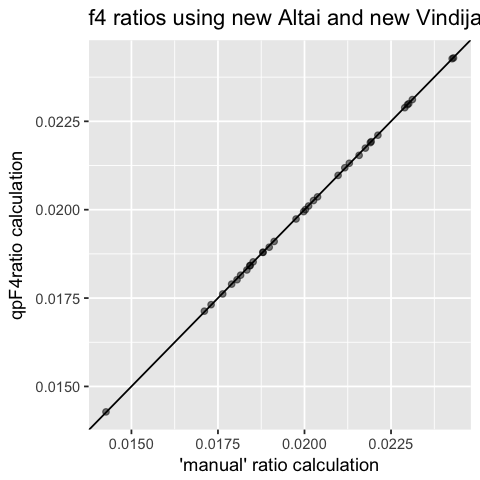

In [9]:
options(repr.plot.width=4, repr.plot.height=4)

inner_join(two_f4, f4_ratio, by=c("W"="X")) %>%
ggplot(aes(two_f4,  f4_ratio)) +
    geom_point(alpha=1/2) +
    geom_abline(slope=1) +
    labs(title="f4 ratios using new Altai and new Vindija",
         x="'manual' ratio calculation", y="qpF4ratio calculation")

Both approaches give exactly the same result (as expected). So I can use the individual f4 for debugging purposes.

<br><br><br>
# My f4 ratios on Qiaomei's dataset vs Steffi's f4 ratios on her dataset

Load Steffi's results:

In [37]:
suppressMessages({
    
steffi_df <- bind_rows(
    read_table2("../raw_data/steffi/results_usti_test/f4_ratios") %>% mutate(set="steffi_f4_vcf_all"),
    read_table2("../raw_data/steffi/results_usti_test_array/f4_ratios") %>% mutate(set="steffi_f4_vcf_intersect")
    ) %>% 
    filter(pop3 == "Altai", pop2 == "Mbuti") %>% 
    mutate(pop1=ifelse(pop1 == "Ust_Ishim", "UstIshim", pop1)) %>% 
    left_join(samples, by=c("pop1"="name")) %>%
    rename(name=pop1)

steffi_f4 <- steffi_df %>% select(name, f4_ratio, set, pop) %>% spread(set, f4_ratio)

})

## My f4 on Qiaomei's 2.2M sites vs Steffi's f4 on her whole VCF

In [11]:
my_f4_qiaomei_all <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp",
                         prefix=EIGENSTRAT) %>% rename(my_f4_qiaomei_all=alpha)

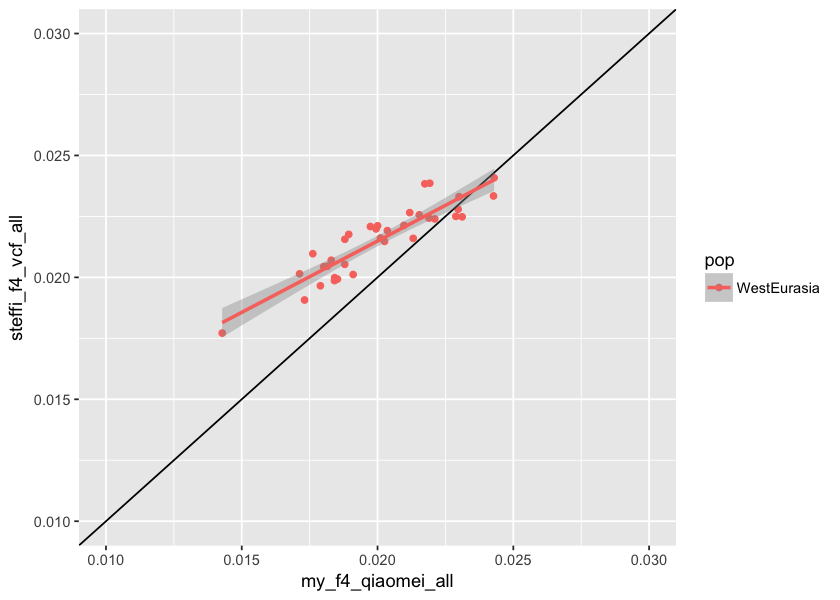

In [12]:
options(repr.plot.width=7, repr.plot.height=5)

inner_join(my_f4_qiaomei_all, steffi_f4, by=c("X"="name")) %>% filter(pop == "WestEurasia")  %>% 
    ggplot(aes(my_f4_qiaomei_all, steffi_f4_vcf_all, color=pop)) +
    geom_point() +
    geom_abline(slope=1) +
    geom_smooth(method="lm") +
    coord_cartesian(x=c(0.01, 0.03), y=c(0.01, 0.03))

## My f4 on Qiaomei's 2.2M sites vs Steffi's f4 on her VCF intersect (~250k of sites)

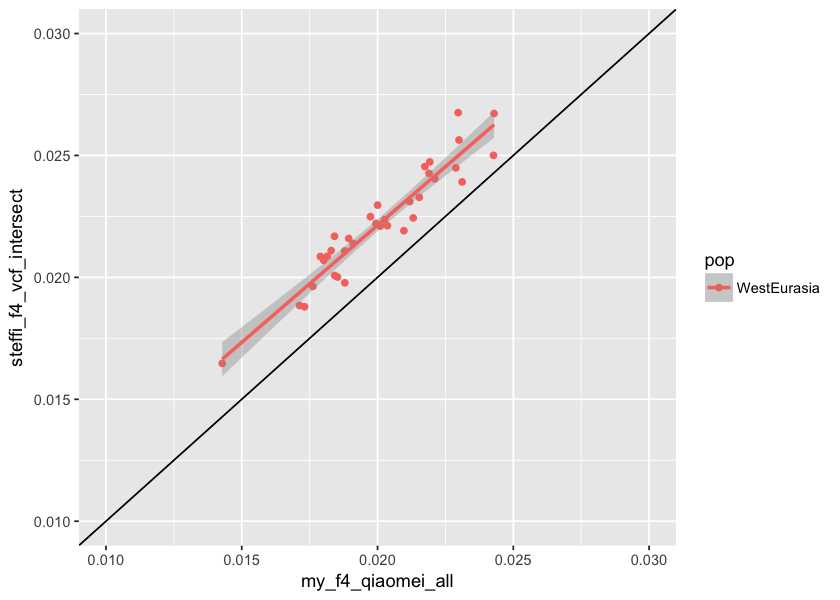

In [13]:
options(repr.plot.width=7, repr.plot.height=5)

inner_join(my_f4_qiaomei_all, steffi_f4, by=c("X"="name")) %>% filter(pop == "WestEurasia")  %>% 
    ggplot(aes(my_f4_qiaomei_all, steffi_f4_vcf_intersect, color=pop)) +
    geom_point() +
    geom_abline(slope=1) +
    geom_smooth(method="lm") +
    coord_cartesian(x=c(0.01, 0.03), y=c(0.01, 0.03))

## My f4 on Steffi's 250k sites VCF subset vs Steffi's f4 on the same data

This uses the same data (EIGENSTRAT generated from VCF and the VCF itself).

**Any potential difference is caused by the computation of Admixtools vs Steffi's script.**

In [14]:
EIGENSTRAT_DIR <- "../raw_data/merged_vcfs/"
STEFFI_EIGENSTRAT <- paste0(EIGENSTRAT_DIR, "steffi")

STEFFI_EIGENSTRAT_INTERSECT <- paste0(STEFFI_EIGENSTRAT, "_intersect")

In [15]:
suppressMessages(
    subset_sites(STEFFI_EIGENSTRAT, STEFFI_EIGENSTRAT_INTERSECT, pos_file="../raw_data/eigenstrat_all/sites.pos")
)

[1] TRUE

In [16]:
my_f4_vcf_intersect <- qpF4ratio(X=filter(samples, !pop %in% c("EMH", "Oceania"))$name, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp",
                                 prefix=STEFFI_EIGENSTRAT_INTERSECT) %>% 
    rename(my_f4_vcf_intersect=alpha)

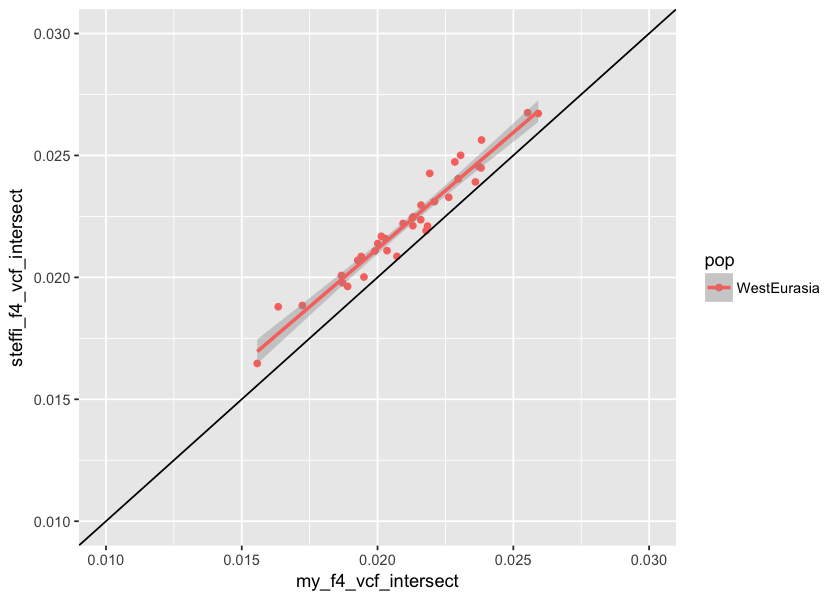

In [17]:
options(repr.plot.width=7, repr.plot.height=5)

inner_join(my_f4_vcf_intersect, steffi_f4, by=c("X"="name")) %>% filter(pop == "WestEurasia")  %>% 
    ggplot(aes(my_f4_vcf_intersect, steffi_f4_vcf_intersect, color=pop)) +
    geom_point() +
    geom_abline(slope=1) +
    geom_smooth(method="lm") +
    coord_cartesian(x=c(0.01, 0.03), y=c(0.01, 0.03))

Both sets were calculated on the same data, but one using Admixtools (x axis) and another using Steffi's scripts (y axis).

## My f4 on all 2.2M sites from Qiaomei vs my f4 on subset of Steffi's VCF (~250k sites)

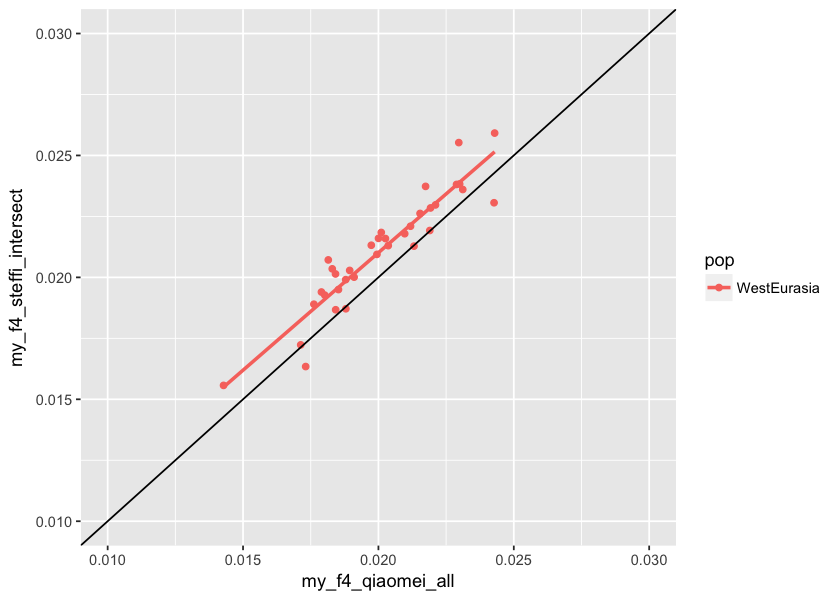

In [18]:
options(repr.plot.width=7, repr.plot.height=5)

inner_join(my_f4_qiaomei_all, my_f4_steffi_intersect, by="X") %>% inner_join(samples, by=c("X"="name")) %>%
filter(pop == "WestEurasia")  %>% 
    ggplot(aes(my_f4_qiaomei_all, my_f4_steffi_intersect, color=pop)) +
    geom_point() +
    geom_abline(slope=1) +
    geom_smooth(method="lm", se=FALSE) +
    coord_cartesian(x=c(0.01, 0.03), y=c(0.01, 0.03))

## My f4 on 250k subset of Qiaomei's data vs my f4 on subset of Steffi's VCF (~250k sites)

Is there a difference in data processing?

In [19]:
EIGENSTRAT_DIR <- "../raw_data/eigenstrat_all//"
EIGENSTRAT <- paste0(EIGENSTRAT_DIR, "UPA_merged_all")

EIGENSTRAT_INTERSECT <- paste0(EIGENSTRAT, "_intersect")

In [20]:
suppressMessages(
    subset_sites(EIGENSTRAT, EIGENSTRAT_INTERSECT, pos_file="../raw_data/merged_vcfs/sites.pos")
)

[1] TRUE

In [21]:
my_f4_qiaomei_intersect <- qpF4ratio(X=filter(samples, !pop %in% c("EMH", "Oceania"))$name, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp",
                                 prefix=EIGENSTRAT_INTERSECT) %>% 
    rename(my_f4_qiaomei_intersect=alpha)

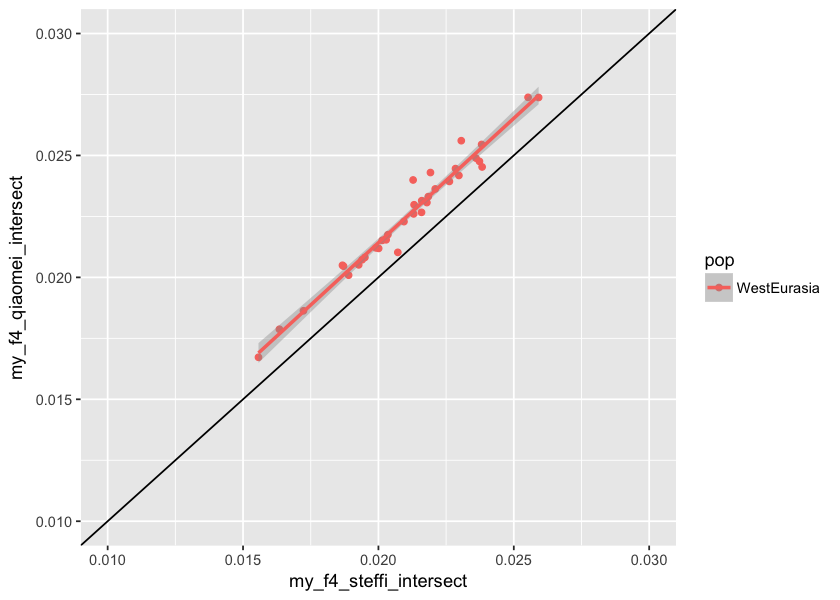

In [22]:
options(repr.plot.width=7, repr.plot.height=5)

inner_join(my_f4_steffi_intersect, my_f4_qiaomei_intersect, by="X") %>% inner_join(samples, by=c("X"="name")) %>%
filter(pop == "WestEurasia") %>% 
    ggplot(aes(my_f4_steffi_intersect, my_f4_qiaomei_intersect, color=pop)) +
    geom_point() +
    geom_abline(slope=1) +
    geom_smooth(method="lm") +
    coord_cartesian(x=c(0.01, 0.03), y=c(0.01, 0.03))

This is strange. So the "Any potential difference is caused by the computation of Admixtools vs Steffi's script." is not correct?

## All sites vs subset on Steffi's data, also using Qiaomei's data

In [48]:
my_f4_vcf_all <- qpF4ratio(X=filter(samples, !pop %in% c("EMH", "Oceania"))$name, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp",
                           prefix=STEFFI_EIGENSTRAT) %>% 
    rename(my_f4_vcf_all=alpha)

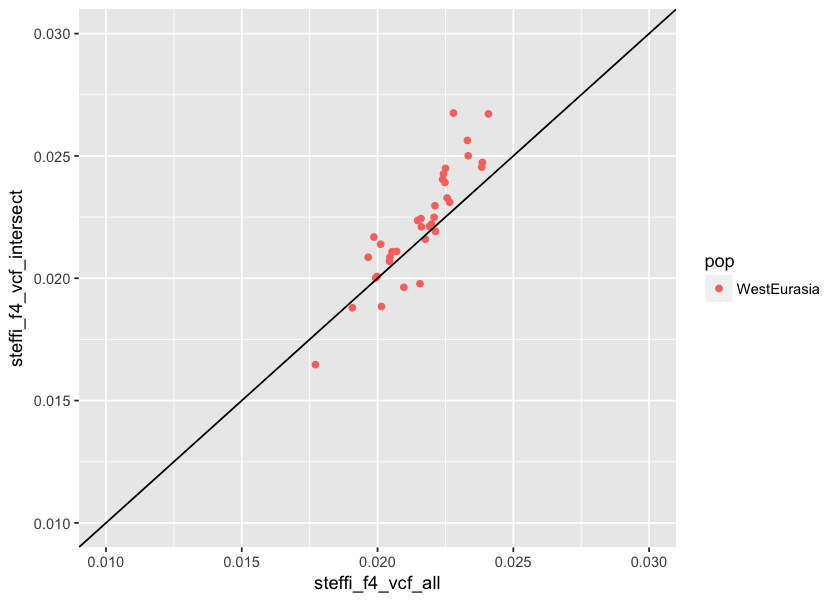

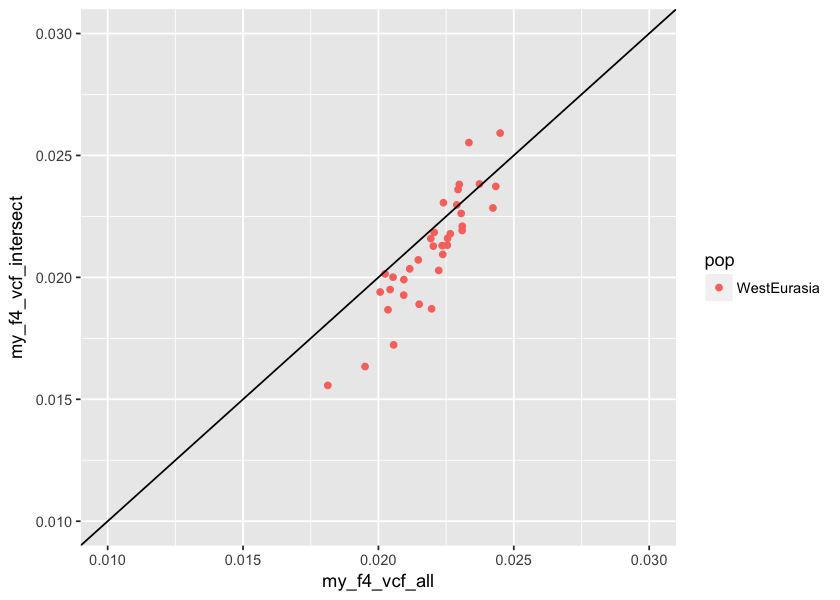

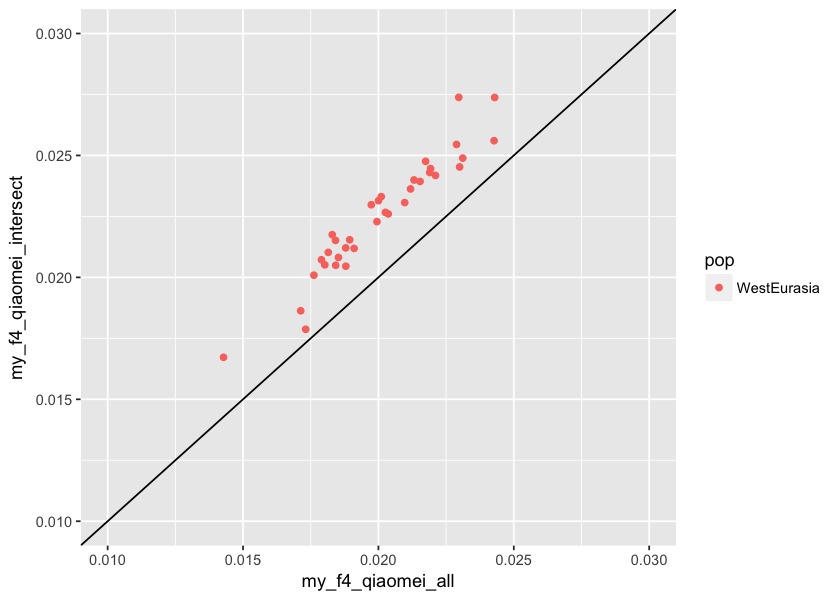

In [54]:
options(repr.plot.width=7, repr.plot.height=5)

steffi_f4 %>%
filter(pop == "WestEurasia") %>% 
    ggplot(aes(steffi_f4_vcf_all, steffi_f4_vcf_intersect, color=pop)) +
    geom_point() +
    geom_abline(slope=1) +
    coord_cartesian(x=c(0.01, 0.03), y=c(0.01, 0.03))

options(repr.plot.width=7, repr.plot.height=5)

inner_join(my_f4_vcf_all, my_f4_vcf_intersect, by="X") %>% inner_join(samples, by=c("X"="name")) %>%
filter(pop == "WestEurasia") %>% 
    ggplot(aes(my_f4_vcf_all, my_f4_vcf_intersect, color=pop)) +
    geom_point() +
    geom_abline(slope=1) +
    coord_cartesian(x=c(0.01, 0.03), y=c(0.01, 0.03))

options(repr.plot.width=7, repr.plot.height=5)

inner_join(my_f4_qiaomei_all, my_f4_qiaomei_intersect, by="X") %>% inner_join(samples, by=c("X"="name")) %>%
filter(pop == "WestEurasia") %>% 
    ggplot(aes(my_f4_qiaomei_all, my_f4_qiaomei_intersect, color=pop)) +
    geom_point() +
    geom_abline(slope=1) +
    coord_cartesian(x=c(0.01, 0.03), y=c(0.01, 0.03))

In [40]:
save.image("../RData/admixtools_debugging.RData")

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

# TODO repeat this using individual f4s, to get ABBA & BABA counts

# calculate my f4 on the 250k subset but FROM QIAOMEI'S ORIGINAL DATA

## My f4 ratios on Steffi's data - complement

In [20]:
EIGENSTRAT_DIR <- "../raw_data/merged_vcfs/"
EIGENSTRAT <- paste0(EIGENSTRAT_DIR, "steffi")

EIGENSTRAT_SUBSET <- paste0(EIGENSTRAT, "_complement")

In [21]:
s <- c("Ust_Ishim", filter(samples, ! pop %in% c("EMH", "Oceania"))$name)

In [22]:
EIGENSTRAT_SUBSET

[1] "../raw_data/merged_vcfs/steffi_complement"

In [24]:
subset_sites(EIGENSTRAT, EIGENSTRAT_SUBSET, pos_file="../raw_data/eigenstrat_all/sites.pos", complement=TRUE)

Parsed with column specification:
cols(
  chrom = col_integer(),
  pos = col_integer()
)
Parsed with column specification:
cols(
  .default = col_integer()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  id = col_character(),
  chrom = col_integer(),
  gen = col_double(),
  pos = col_integer(),
  alt = col_character(),
  ref = col_character()
)
Joining, by = c("chrom", "pos")


[1] TRUE

### Merge this "manual" f4 ratio data.frame with the `qpF4ratio` results for the same setup

In [26]:
f4_steffi_complement <- qpF4ratio(X=s, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp", prefix=EIGENSTRAT_SUBSET,
                         dir_name="../admixtools") %>%
    rename(steffi_complement=alpha) %>% mutate(name=X)

### Plot the correlation of both

Run on the exact subset:

Joining, by = "name"


Joining, by = "name"


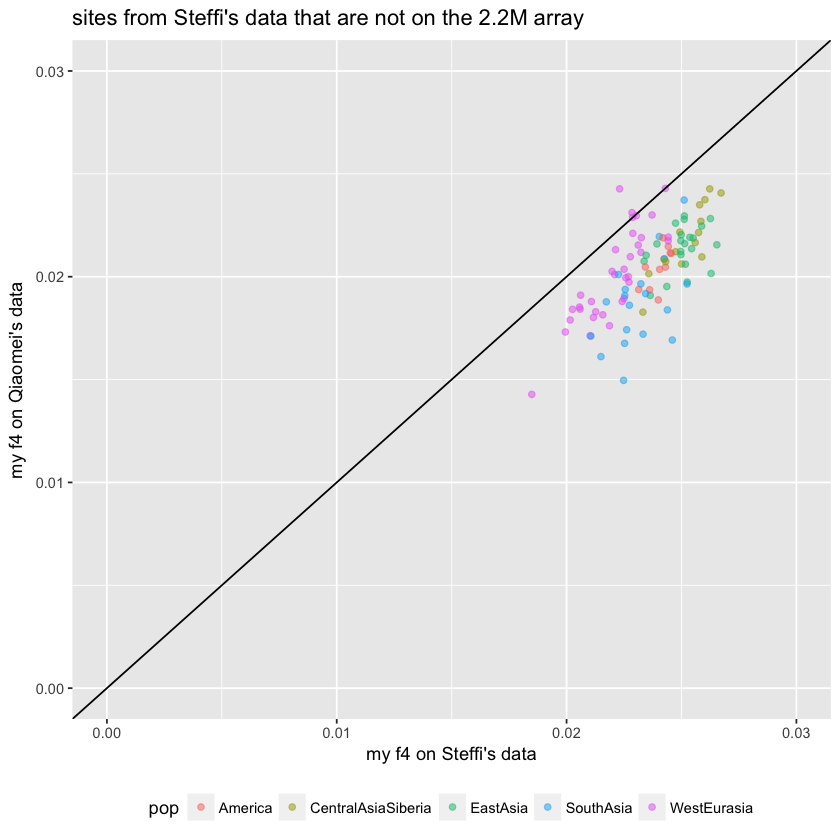

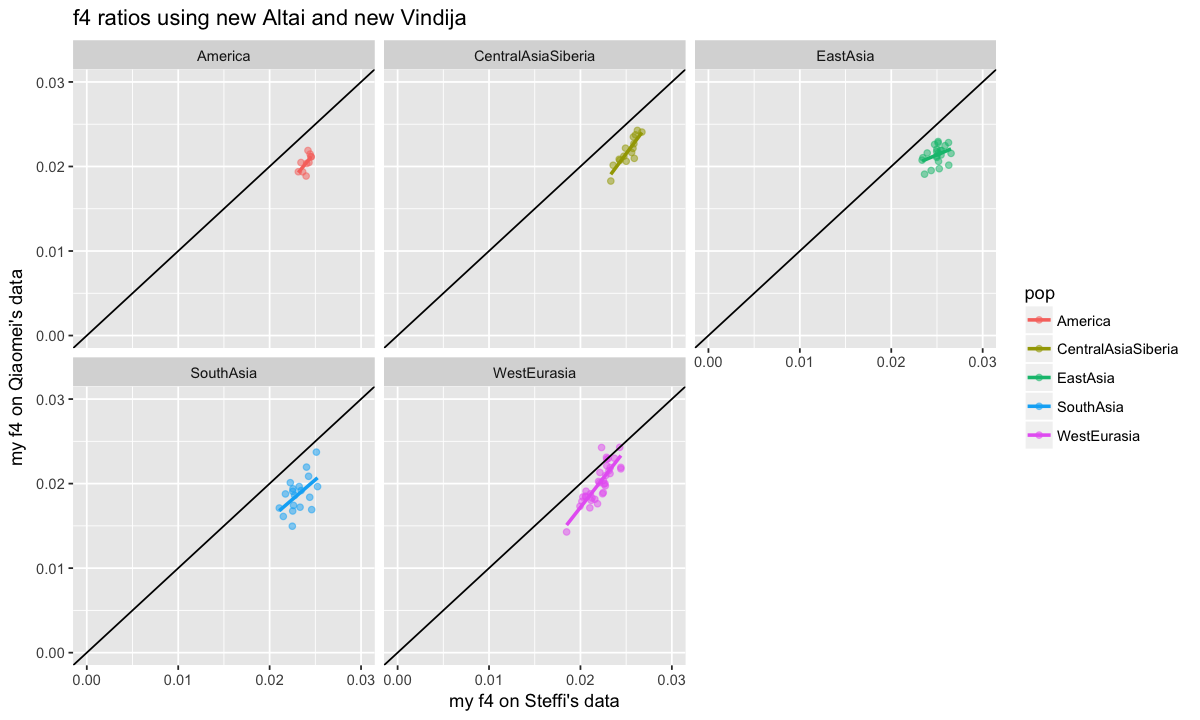

In [40]:
options(repr.plot.width=7, repr.plot.height=7)

inner_join(f4_steffi_complement, f4b, by="name") %>% inner_join(samples) %>% 
ggplot(aes(steffi_complement,  admixtools_b, color=pop)) +
    geom_point(alpha=1/2) +
    geom_abline(slope=1) +
    coord_cartesian(x=c(0, 0.03), y=c(0, 0.03)) +
    labs(title="sites from Steffi's data that are not on the 2.2M array",
         x="my f4 on Steffi's data", y="my f4 on Qiaomei's data") +
    theme(legend.position="bottom")

options(repr.plot.width=10, repr.plot.height=6)

inner_join(f4_steffi_complement, f4b, by="name") %>% inner_join(samples) %>% 
ggplot(aes(steffi_complement,  admixtools_b, color=pop)) +
    geom_point(alpha=1/2) +
    geom_abline(slope=1) +
    facet_wrap(~ pop) +
    geom_smooth(method="lm", se=FALSE) +
    coord_cartesian(x=c(0, 0.03), y=c(0, 0.03)) +
    labs(title="f4 ratios using new Altai and new Vindija",
         x="my f4 on Steffi's data", y="my f4 on Qiaomei's data")

## Comparison with Steffi's f4 ratios

In [80]:
load("../RData/nea_estimates.RData")

In [81]:
suppressMessages({

steffi_df <- bind_rows(list(
    read_table2("../raw_data/steffi/results_usti_test/f4_ratios") %>% mutate(set="all"),
    read_table2("../raw_data/steffi/results_usti_test_array/f4_ratios") %>% mutate(set="array")
    )) %>% 
    filter(pop3 == "Altai", pop2 == "Mbuti") %>% 
    mutate(pop1=ifelse(pop1 == "Ust_Ishim", "UstIshim", pop1)) %>% 
    left_join(samples, by=c("pop1"="name")) %>%
    rename(name=pop1)

})

steffi_nea <- steffi_df %>% select(name, f4_ratio, set, pop) %>% spread(set, f4_ratio) %>%
    rename(steffi_all=all, steffi_array=array)

In [82]:
steffi_nea %>% head

name,pop,steffi_all,steffi_array
Abkhasian,WestEurasia,0.01993022,0.02001503
Adygei,WestEurasia,0.02330924,0.02563313
Albanian,WestEurasia,0.02408386,0.02671752
Aleut,CentralAsiaSiberia,0.02523005,0.02532569
Altaian,CentralAsiaSiberia,0.02613542,0.02702200
Ami,EastAsia,0.02532708,0.02458556


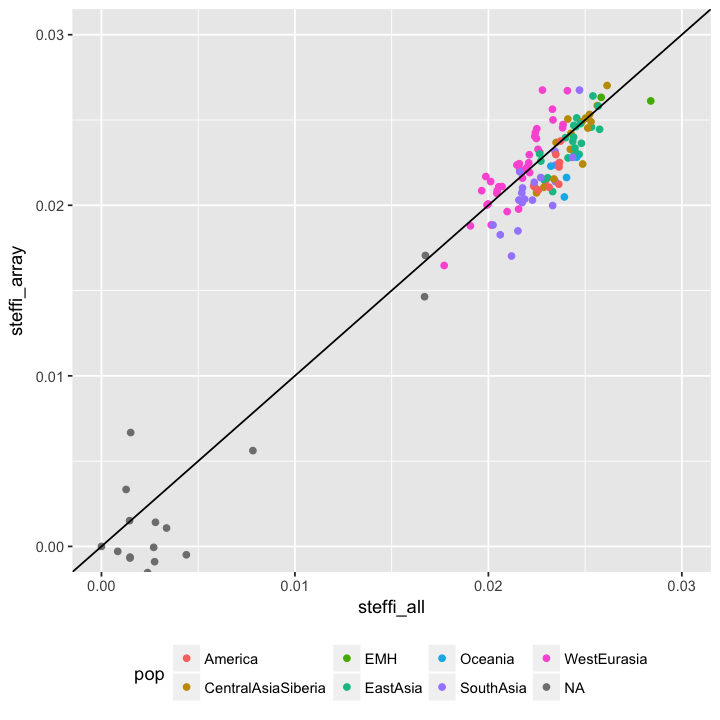

In [91]:
options(repr.plot.width=6, repr.plot.height=6, repr.plot.res=120)

ggplot(steffi_nea, aes(steffi_all, steffi_array, color=pop)) +
    geom_point() +
    geom_abline(slope=1) +
    theme(legend.position="bottom") + coord_cartesian(x=c(0, 0.03), y=c(0, 0.03))